In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings
import seaborn as sns
sns.set()
np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [129]:
# read data from file
train = pd.read_csv("/home/nishant/pro_nis/python_codes/one_fourth_labs/data/padhai-module1-assignment/train.csv") 
test = pd.read_csv("/home/nishant/pro_nis/python_codes/one_fourth_labs/data/padhai-module1-assignment/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


**To find which columns have more empty columns: (150 or more)**

In [130]:
train.loc[:,train.isna().sum()>150].columns  #train.isna().sum() gives how many 'na' values are there in train

Index(['Also Known As', 'Applications', 'Aspect Ratio', 'Audio Features',
       'Bezel-less display', 'Browser', 'Build Material', 'Co-Processor',
       'Custom UI', 'Display Colour', 'Email', 'Games', 'HDMI',
       'Heart Rate Monitor', 'IRIS Scanner', 'Java',
       'Mobile High-Definition Link(MHL)', 'Music',
       'Optical Image Stabilisation', 'Other Facilities', 'Phone Book',
       'Ring Tone', 'Ruggedness', 'SAR Value', 'SIM 3', 'SMS',
       'Screen Protection', 'Screen to Body Ratio (claimed by the brand)',
       'Sensor', 'Software Based Aperture', 'Special Features', 'Standby time',
       'Stylus', 'TalkTime', 'USB Type-C', 'User Available Storage',
       'Video Player', 'Video Recording Features', 'Waterproof',
       'Wireless Charging'],
      dtype='object')

In [131]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [132]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [133]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [134]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [135]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [136]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [137]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [138]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [139]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [140]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Internal Memory', 'Processor_frequency', 'Brand', 'os_name',
       'SIM Slot(s)', 'SIM 2', 'Weight', 'Resolution', 'Sim1', 'Height',
       'Screen Size', 'Pixel Density', 'Num_cores',
       'Screen to Body Ratio (calculated)', 'RAM', 'Capacity'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Internal Memory', 'Processor_frequency', 'Weight',
       'Resolution', 'Height', 'Screen Size', 'Pixel Density',
       'Screen to Body Ratio (calculated)', 'RAM', 'Capacity', 'Brand_10.or',
       'Brand_Apple', 'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry',
       'Brand_Comio', 'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee',
       'Brand_Google', 'Brand_HTC', 'Brand_Honor', 'Brand_Huawei',
       'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex', 'Brand_Itel',
       'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava', 'Brand_LeEco',
       'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf', 'Brand_Meizu',
       'Brand_Micromax', 'Brand_Mobiistar', 'Brand_Mot

In [141]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [142]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [143]:
train_new.head()

,PhoneId,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Rating
0,0,64,1.8,182,20,157.9,6.26,403,80.68,4,4000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,4.5
1,1,32,1.8,168,8,156.2,6.20,271,80.85,3,4230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,4.5
2,2,32,2.1,168,25,157.0,6.30,409,83.68,3,3500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,4.4
3,4,64,2.2,169,24,159.8,6.00,411,74.78,4,3300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,4.3
4,5,64,2.2,175,16,160.4,6.50,396,84.23,4,3750,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,4.4


In [144]:
test_new.shape

(119, 87)

# My code here

**increase the number of columns to be seen**

In [145]:
pd.set_option('display.max_columns',100)

In [146]:
train_new.columns[~train_new.columns.isin(test_new.columns)]

Index(['Rating'], dtype='object')

Thus, rating is the column missing in the test data set, we have to find that column (binary version of that.)

In [147]:
y_train= train_new.Rating.copy()

**Those having ratings less than 4 are considered as disliked, above it are liked**

In [153]:
y_train.tail(15)

326    4.2
327    4.1
328    4.0
329    3.9
330    3.7
331    4.2
332    4.0
333    3.6
334    3.6
335    4.4
336    3.8
337    3.9
338    4.1
339    3.6
340    4.3
Name: Rating, dtype: float64

In [163]:
y_train=np.where(y_train<4,0,1)
y_train= pd.Series(y_train)
type(y_train)

pandas.core.series.Series

In [72]:
y_train= y_train.map(lambda x: 0 if x<THRESHOLD else 1)

In [73]:
y_train.value_counts()

1    238
0    103
Name: Rating, dtype: int64

**We won't need the phoneId to be used in decision making. Also, we drop Rating because it is used in y_train.**

In [74]:
X_train= train_new.drop(columns='Rating',axis=1)

In [75]:
X_train.shape

(341, 87)

In [76]:
X_test= test_new.copy()

In [77]:
X_test.shape

(119, 87)

In [78]:
X_train.columns

Index(['PhoneId', 'Internal Memory', 'Processor_frequency', 'Weight',
       'Resolution', 'Height', 'Screen Size', 'Pixel Density',
       'Screen to Body Ratio (calculated)', 'RAM', 'Capacity', 'Brand_10.or',
       'Brand_Apple', 'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry',
       'Brand_Comio', 'Brand_Coolpad', 'Brand_Do', 'Brand_Gionee',
       'Brand_Google', 'Brand_HTC', 'Brand_Honor', 'Brand_Huawei',
       'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex', 'Brand_Itel',
       'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava', 'Brand_LeEco',
       'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf', 'Brand_Meizu',
       'Brand_Micromax', 'Brand_Mobiistar', 'Brand_Moto', 'Brand_Motorola',
       'Brand_Nokia', 'Brand_Nubia', 'Brand_OPPO', 'Brand_OnePlus',
       'Brand_Oppo', 'Brand_Panasonic', 'Brand_Razer', 'Brand_Realme',
       'Brand_Reliance', 'Brand_Samsung', 'Brand_Sony', 'Brand_Spice',
       'Brand_Tecno', 'Brand_Ulefone', 'Brand_VOTO', 'Brand_Vivo',
       'Bran

___

**Removing these features is not giving a good result on test**

In [79]:
# X_train= X_train.drop(columns=['Pixel Density','Screen to Body Ratio (calculated)','Resolution',
#                                 ],axis=1)

In [80]:
# X_test= X_test.drop(columns=['Pixel Density','Screen to Body Ratio (calculated)','Resolution',
#                                 ],axis=1)

___

In [81]:
X_train_phoneid= X_train['PhoneId']
X_test_phoneid= X_test['PhoneId']
X_train.drop(columns='PhoneId',axis=1,inplace=True)
X_test.drop(columns='PhoneId',axis=1,inplace=True)
print(X_test.shape)
print(X_train.shape)

(119, 86)
(341, 86)


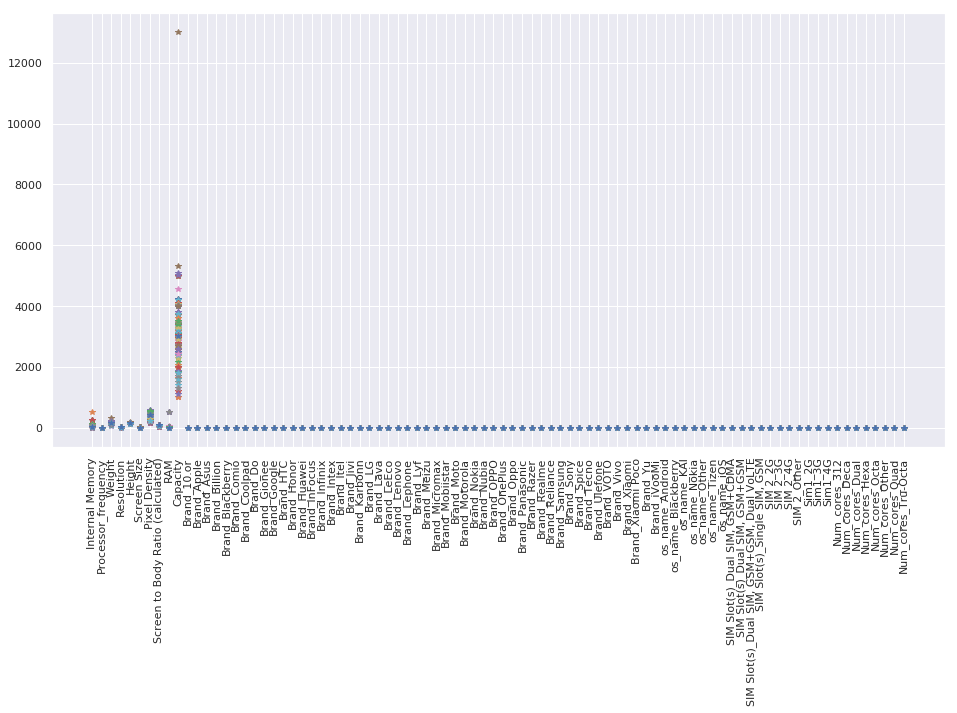

In [82]:
plt.figure(figsize=(16,8))
plt.plot(X_train.T,'*')
plt.xticks(rotation=90)
plt.show()

**Above, we can see that some of the values are varying alot, while most are binary. Hence if we consider a threshold above 1, most of the features will be ignored. To get over this situation, it's good to normalise.**

we have now, **X_train,y_train,X_test** but we need to normalise it:

# **Normalising the data**

On some close inspection, it can be seen, that one of the values in RAM is 512, which has to be 512 MB. This need further processing and converted to 0.5

In [83]:
X_train['RAM'][X_train.RAM>10]

46     512
57     512
74     512
113     16
136     64
183     32
184    512
297    512
Name: RAM, dtype: int64

In [84]:
X_test["RAM"][X_test.RAM>10]

36     512
112    512
Name: RAM, dtype: int64

In [85]:
X_train['RAM'].where(X_train.RAM!=512,0.5,inplace=True)
X_test['RAM'].where(X_test.RAM!=512,0.5,inplace=True)

In [86]:
X_train.head()

,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,64,1.8,182,20,157.9,6.26,403,80.68,4.0,4000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,32,1.8,168,8,156.2,6.20,271,80.85,3.0,4230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,32,2.1,168,25,157.0,6.30,409,83.68,3.0,3500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
3,64,2.2,169,24,159.8,6.00,411,74.78,4.0,3300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
4,64,2.2,175,16,160.4,6.50,396,84.23,4.0,3750,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [87]:
X_test.head()

,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,16,1.8,168,5,156.2,6.20,271,80.85,2.0,4230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,64,1.8,205,12,156.0,6.20,402,81.60,4.0,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
2,64,2.0,169,25,156.7,6.30,409,83.84,6.0,3500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
3,64,2.0,169,16,156.7,6.30,409,83.84,4.0,3500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
4,64,1.8,181,20,158.6,5.99,403,77.43,4.0,4000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [88]:
for i in range(X_train.shape[1]):
    minimum= X_train.min()[i]
    maximum= X_train.max()[i]
    X_train.iloc[:,i]=X_train.iloc[:,i].apply(lambda x: (x-minimum)/(maximum-minimum))
    


In [89]:
for i in range(X_test.shape[1]):
    minimum= X_test.min()[i]
    maximum= X_test.max()[i]
    X_test.iloc[:,i]=X_test.iloc[:,i].apply(lambda x: (x-minimum)/(maximum-minimum))
    


In [90]:
X_train.head()

,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,0.1250,0.444444,0.455882,0.782609,0.723077,0.921241,0.600462,0.891040,0.055118,0.248748,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0625,0.444444,0.404412,0.260870,0.694017,0.906921,0.295612,0.893693,0.039370,0.267947,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0625,0.611111,0.404412,1.000000,0.707692,0.930788,0.614319,0.937871,0.039370,0.207012,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.1250,0.666667,0.408088,0.956522,0.755556,0.859189,0.618938,0.798938,0.055118,0.190317,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.1250,0.666667,0.430147,0.608696,0.765812,0.978520,0.584296,0.946456,0.055118,0.227880,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**We can see that those with NAN are all 0 or they can be all 1.** We have to check those columns.

In [91]:
X_train.isna().any().sum()   #all these values were 0 (confirmed from train_new)

3

In [92]:
X_test.head()

,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,0.0625,0.376344,0.557522,0.130435,0.717496,0.936170,0.248811,0.931169,0.200000,0.806533,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN
1,0.2500,0.376344,0.884956,0.434783,0.714286,0.936170,0.456418,0.942441,0.466667,1.000000,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN
2,0.2500,0.483871,0.566372,1.000000,0.725522,0.957447,0.467512,0.976105,0.733333,0.623116,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN
3,0.2500,0.483871,0.566372,0.608696,0.725522,0.957447,0.467512,0.976105,0.466667,0.623116,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN
4,0.2500,0.376344,0.672566,0.782609,0.756019,0.891489,0.458003,0.879772,0.466667,0.748744,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN


In [93]:
X_test.isna().any().sum()

22

In [94]:
test_new.shape[1]-test_new[test_new==0].isna().any().sum() 

22

thus all values in X_test that are NAN were 0

**We can safely replace all those NAN with 0**.

In [95]:
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

In [96]:
X_train.head()

,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,0.1250,0.444444,0.455882,0.782609,0.723077,0.921241,0.600462,0.891040,0.055118,0.248748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0625,0.444444,0.404412,0.260870,0.694017,0.906921,0.295612,0.893693,0.039370,0.267947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0625,0.611111,0.404412,1.000000,0.707692,0.930788,0.614319,0.937871,0.039370,0.207012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.1250,0.666667,0.408088,0.956522,0.755556,0.859189,0.618938,0.798938,0.055118,0.190317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.1250,0.666667,0.430147,0.608696,0.765812,0.978520,0.584296,0.946456,0.055118,0.227880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [97]:
X_test.head()

,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
0,0.0625,0.376344,0.557522,0.130435,0.717496,0.936170,0.248811,0.931169,0.200000,0.806533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.2500,0.376344,0.884956,0.434783,0.714286,0.936170,0.456418,0.942441,0.466667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.2500,0.483871,0.566372,1.000000,0.725522,0.957447,0.467512,0.976105,0.733333,0.623116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.2500,0.483871,0.566372,0.608696,0.725522,0.957447,0.467512,0.976105,0.466667,0.623116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.2500,0.376344,0.672566,0.782609,0.756019,0.891489,0.458003,0.879772,0.466667,0.748744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Binarisation

Also check the result for the mean of each column for binarisation (in that case, normalisation was not needed in MP neuron.)

## **Approach 3:**  (submitted approach)

### **Doing some random checks**
___

In [98]:
X_train_dummy= X_train.copy()

In [99]:
X_train_dummy['r']= y_train

In [100]:
X_train_dummy=X_train_dummy.groupby('r').mean()
X_train_dummy

# print(X_train_dummy[X_train_dummy['r']==0][0].mean())
# print(X_train_dummy[X_train_dummy['r']==1][0].mean())


,Internal Memory,Processor_frequency,Weight,Resolution,Height,Screen Size,Pixel Density,Screen to Body Ratio (calculated),RAM,Capacity,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa
r,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.059238,0.315804,0.370752,0.243563,0.536424,0.659592,0.425211,0.710093,0.034860,0.164007,0.019417,0.000000,0.009709,0.0,0.038835,0.000000,0.019417,0.0,0.038835,0.000000,0.048544,0.019417,0.00000,0.029126,0.009709,0.038835,0.009709,0.009709,0.019417,0.058252,0.019417,0.000000,0.058252,0.009709,0.009709,0.000000,0.116505,0.029126,0.048544,0.000000,0.077670,0.009709,0.000000,0.000000,0.009709,0.019417,0.009709,0.000000,0.009709,0.058252,0.048544,0.0,0.009709,0.000000,0.009709,0.019417,0.019417,0.000000,0.029126,0.009709,0.932039,0.019417,0.019417,0.000000,0.019417,0.009709,0.000000,0.000000,0.902913,0.038835,0.058252,0.330097,0.029126,0.582524,0.058252,0.009709,0.048544,0.941748,0.000000,0.019417,0.038835,0.009709,0.436893,0.009709,0.485437,0.000000
1,0.104123,0.494188,0.383913,0.367556,0.609057,0.761708,0.481777,0.783114,0.055317,0.188704,0.000000,0.079832,0.029412,0.0,0.004202,0.004202,0.000000,0.0,0.025210,0.016807,0.004202,0.063025,0.02521,0.000000,0.008403,0.000000,0.012605,0.000000,0.000000,0.012605,0.016807,0.004202,0.037815,0.000000,0.000000,0.008403,0.012605,0.004202,0.042017,0.008403,0.054622,0.000000,0.058824,0.012605,0.021008,0.008403,0.000000,0.016807,0.000000,0.159664,0.016807,0.0,0.029412,0.004202,0.000000,0.100840,0.079832,0.012605,0.004202,0.000000,0.894958,0.000000,0.000000,0.004202,0.021008,0.000000,0.079832,0.004202,0.697479,0.201681,0.096639,0.159664,0.016807,0.726891,0.096639,0.025210,0.008403,0.966387,0.004202,0.000000,0.025210,0.046218,0.642857,0.021008,0.256303,0.004202


**Some values for 0 are greater than 1, others are less. I would try to apply different cut for the two parts:**

**ready to cut differently and then combine the two**

In [101]:
part=X_train_dummy.iloc[1,:]>=X_train_dummy.iloc[0,:]
part_1_greater_than_0= part[part==True].index
part_0_greater_than_1= part[part==False].index

In [102]:
X_binarised_train_3_01= X_train[part_1_greater_than_0]
X_binarised_train_3_10= X_train[part_0_greater_than_1]

X_binarised_test_3_01= X_test[part_1_greater_than_0]
X_binarised_test_3_10= X_test[part_0_greater_than_1]


X_binarised_train_3_01= X_binarised_train_3_01.apply(pd.cut,bins=2,labels=[0,1])
X_binarised_test_3_01 = X_binarised_test_3_01.apply(pd.cut,bins=2, labels=[0,1])

X_binarised_train_3_10= X_binarised_train_3_10.apply(pd.cut,bins=2,labels=[1,0])
X_binarised_test_3_10 = X_binarised_test_3_10.apply(pd.cut,bins=2, labels=[1,0])


In [103]:
X_binarised_train_3=pd.concat([X_binarised_train_3_01,X_binarised_train_3_10],axis=1)
X_binarised_test_3=pd.concat([X_binarised_test_3_01,X_binarised_test_3_10],axis=1)

In [104]:
X_binarised_test_3= X_binarised_test_3.values
X_binarised_train_3= X_binarised_train_3.values

___

## **Approach 1:**

___

### with mean (X_binarised_train_1, X_binarised_test_1)

In [105]:
X_binarised_train_1= X_train.copy()

In [106]:
X_binarised_test_1= X_test.copy()

In [107]:
for i in range(X_train.shape[1]):
    X_binarised_train_1.iloc[:,i]= X_train.iloc[:,i].apply(lambda x: 1 if x>=X_train.mean()[i] else 0)

In [108]:
for i in range(X_test.shape[1]):
    X_binarised_test_1.iloc[:,i]= X_test.iloc[:,i].apply(lambda x: 1 if x>=X_test.mean()[i] else 0)

In [109]:
X_binarised_train_1=X_binarised_train_1.values
X_binarised_test_1=X_binarised_test_1.values

___

## **Approach 0:**

___

### With cut (X_binarised_train, X_binarised_test)

In [110]:
X_binarised_train= X_train.apply(pd.cut,bins=2,labels=[0,1])
X_binarised_test = X_test.apply(pd.cut,bins=2, labels=[0,1])

In [111]:
X_binarised_train=X_binarised_train.values
X_binarised_test=X_binarised_test.values

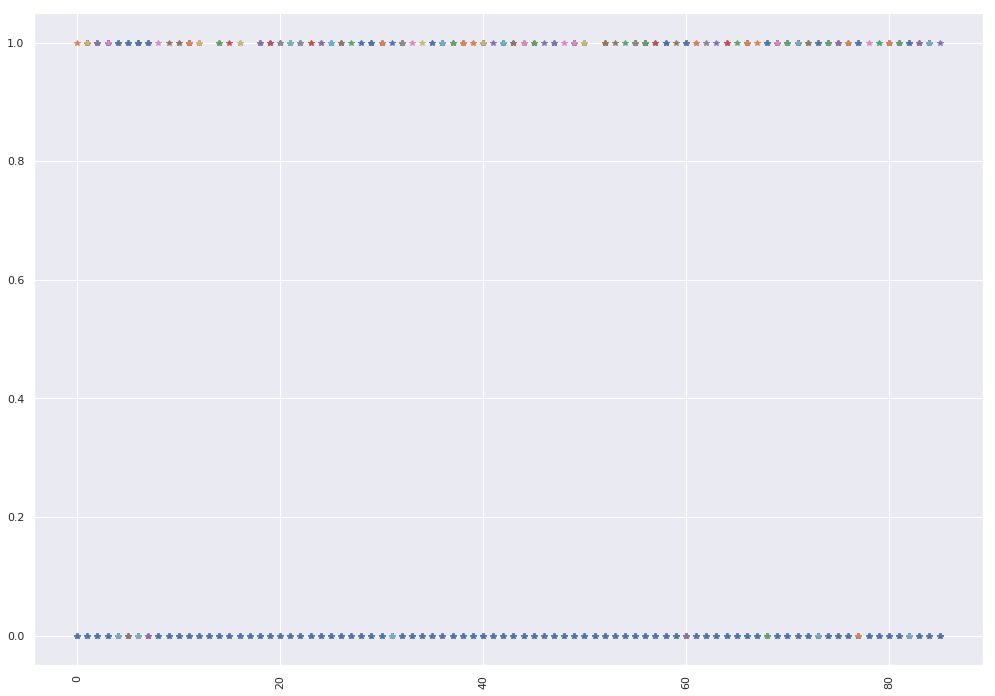

In [112]:
plt.figure(figsize=(17,12))
plt.plot(X_binarised_train.T,'*')
plt.xticks(rotation= 'vertical')
plt.show()

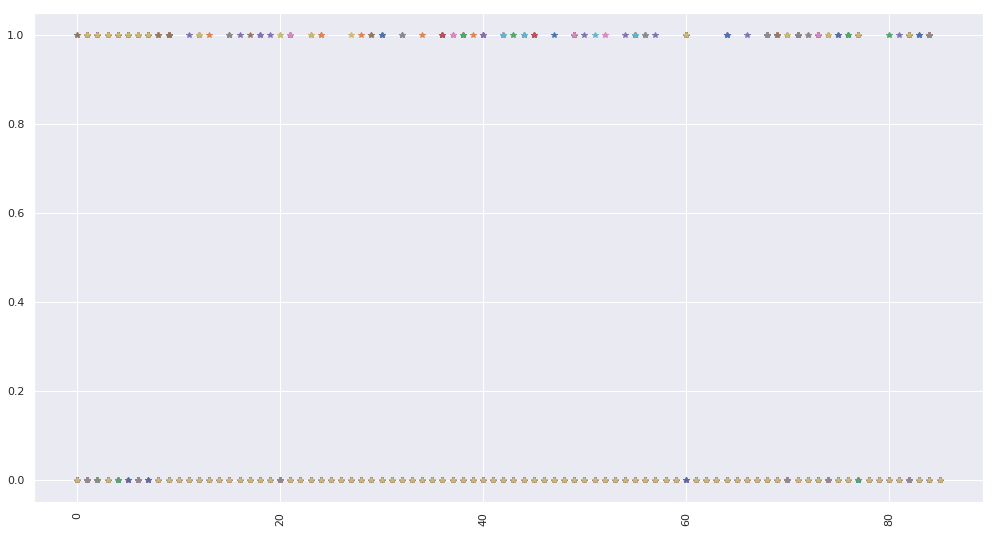

In [113]:
plt.figure(figsize= (17,9))
plt.plot(X_binarised_test.T,'*')
plt.xticks(rotation= 'vertical')
plt.show()

___

## **Approach 2:**

___

# Cutting with different criteria:

In [114]:
X_binarised_train_2= X_train.copy()
for i in range(X_train.shape[1]):
    X_binarised_train_2.iloc[:,i]= X_train.iloc[:,i].apply(lambda x: 1 if x>=X_train_dummy.iloc[:,i].mean() else 0)

In [115]:
X_binarised_test_2= X_test.copy()
for i in range(X_test.shape[1]):
    X_binarised_test_2.iloc[:,i]= X_test.iloc[:,i].apply(lambda x: 1 if x>=X_train_dummy.iloc[:,i].mean() else 0)

In [116]:
X_binarised_test_2.isna().any().sum()

0

In [117]:
X_binarised_train_2= X_binarised_train_2.values
X_binarised_test_2 = X_binarised_test_2.values

___

# Learning

In [118]:
for b in range(X_binarised_train_3.shape[1]+1):
  accurate_prediction=0
  
  for x,z in zip(X_binarised_train_3,y_train):
    y_predicted= (np.sum(x)>=b)
    accurate_prediction+=(y_predicted==z)
  print(b, accurate_prediction/X_binarised_train_3.shape[0])
    

0 0.6979472140762464
1 0.6979472140762464
2 0.6979472140762464
3 0.6979472140762464
4 0.6979472140762464
5 0.6979472140762464
6 0.6979472140762464
7 0.6979472140762464
8 0.6979472140762464
9 0.6979472140762464
10 0.6979472140762464
11 0.6979472140762464
12 0.6979472140762464
13 0.6979472140762464
14 0.6979472140762464
15 0.6979472140762464
16 0.6979472140762464
17 0.6979472140762464
18 0.6979472140762464
19 0.6979472140762464
20 0.6979472140762464
21 0.6979472140762464
22 0.6979472140762464
23 0.6979472140762464
24 0.6979472140762464
25 0.6979472140762464
26 0.6979472140762464
27 0.6979472140762464
28 0.6979472140762464
29 0.6979472140762464
30 0.6979472140762464
31 0.6979472140762464
32 0.6979472140762464
33 0.6979472140762464
34 0.7008797653958945
35 0.7067448680351907
36 0.7155425219941349
37 0.7272727272727273
38 0.7331378299120235
39 0.7126099706744868
40 0.7419354838709677
41 0.7331378299120235
42 0.7096774193548387
43 0.7096774193548387
44 0.6803519061583577
45 0.571847507331378

In [119]:
class MPneuron:
  def __init__(self):
    """only one parameter 'b' in case of MPneuron."""
    self.b= None  #we make it None initially
    
  def model(self,x):
    """returns True for sum >= b, False for sum < b"""
    return (np.sum(x)>=self.b)
  
  def predict(self, X):
    """takes in the entire matrix as an input, and runs the 'model' module on it"""
    Y= []
    for x in X:
      result = self.model(x)
      Y.append(result)
    return np.array(Y)
  
  def fit(self, X, Y):
    """Finding the  best fitting parameters"""
    
    accuracy= {}
    for b in range(X.shape[1]+1):
      self.b = b
      Y_pred= self.predict(X)
      accuracy[b]= accuracy_score(Y_pred,Y)  #Y is the corresponding test/train value that we have
    
    best_b= max(accuracy, key=accuracy.get)   #The key parameter takes a function, and for each entry in the iterable, it'll find the one for which the key function returns the highest value.
    self.b= best_b
    print(f'optimal value for b is {best_b}')
    print(f'maximum accuracy is {accuracy[best_b]}')
            
    plt.plot(accuracy.values())
    plt.show()

optimal value for b is 40
maximum accuracy is 0.7419354838709677


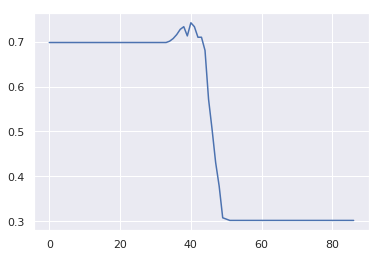

In [120]:
mp_neuron = MPneuron()
mp_neuron.fit(X_binarised_train_3,y_train)

In [121]:
y_test_pred= mp_neuron.predict(X_binarised_test_3)

In [122]:
y_test_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True,  True, False,  True, False, False,  True,
        True,  True, False,  True, False, False,  True,  True,  True,
       False,  True])

In [123]:
submission = pd.DataFrame({'PhoneId':X_test_phoneid, 'Class':y_test_pred*1})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [124]:
submission.Class.value_counts()

1    97
0    22
Name: Class, dtype: int64

In [125]:
submission.to_csv("submission.csv", index=False)

In [126]:
submission.shape

(119, 2)

---
---
***

# Irrelevant (helped someone)

In [185]:
# line = "aeiouAaEeeIiiiOoooooUuuuuuu"
# result={}
# unique= set(line.lower())
# for i in unique:
#     result[i]= line.lower().count(i)

# for j in sorted(result.items(),reverse=True):
#     print(j)